In [21]:
using LinearAlgebra, Statistics#,SparseArrays,Symbolics
using PyCall
using PyPlot
import Seaborn

PyPlot.svg(true)
tkr=pyimport("matplotlib.ticker")

fm=pyimport("matplotlib.font_manager")
font_prop = fm.FontProperties(fname="/Users/mickael/Library/Fonts/Harding Text Web Regular Regular.ttf",size=10, weight="bold");
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 8

font_prop_ticks = fm.FontProperties(fname="/Users/mickael/Library/Fonts/Harding Text Web Regular Regular.ttf",size=8);
font_prop_titles = fm.FontProperties(fname="/Users/mickael/Library/Fonts/Harding Text Web Regular Regular.ttf",size=11, weight="bold");
font_prop_labels = fm.FontProperties(fname="/Users/mickael/Library/Fonts/Harding Text Web Regular Regular.ttf",size=10);
font_prop_legend = fm.FontProperties(fname="/Users/mickael/Library/Fonts/Harding Text Web Regular Regular.ttf",size=6);

respath="../Results/"


"../Results/"

In [ ]:
# Define B matrix for Biophysical interactions
Bo = [
    1.0     0.15    0.38    0.22    0.10    0.19    -0.07   -0.08   0       -0.06   # Climate Change
    0.22    1       0       0       0       0       0.08    0       0       0       # BI Land
    0.17    0       1       0       0       0       0.04    0       0       0       # BI Freshwater
    0.15    0       0       1       0       0       0.06    0       0       0       # BI Ocean
    0.12    0.8     0.08    0       1       0       0.16    -0.11   0       0       # Land System Change
    0.04    0.02    1       0.05    0       1       -0.03   0       0.10    0.01    # Biogeochemical Flows
    0.10    0       0       1       0       0       1       0       0       0       # Ocean Acidification
    0       0       1       0       0       0       0       1       0       0       # Freshwater Use
    -0.56   0       0       0       0       0       0       0       1       0       # Aerosol Loading
    -0.11   0       0       0       0       0       0       0       0       1       # Strat. Ozone Deplet.
    ]'-I(10)

    
# Define R matrix for Reactive human-mediated interactions
R = [
    1       0       0       0       0.05        0       0       0       0       0       # Climate Change
    0       1       0       0       0           0       0       0       0       0       # BI Land
    0.002   0       1       0       0.003       0       0       0       0       0       # BI Freshwater
    0       0       0       1       0.02        0       0       0       0       0       # BI Ocean
    0       0       0       0       1           0       0       0       0       0       # Land System Change
    0       0       0       0       0           1       0       0       0       0       # Biogeochemical Flows
    0       0       0       0       0           0       1       0       0       0       # Ocean Acidification
    0       0       0       0       0           0       0       1       0       0       # Freshwater Use
    0       0       0       0       0           0       0       0       1       0       # Aerosol Loading
    0       0       0       0       0           0       0       0       0       1       # Strat. Ozone Deplet.
    ]'-I(10)

# Define P matrix for Parallel human drivers
P = [
    1       0       0       0       0       0       0.40        0.065       0       0       # Climate Change
    0       1       0       0       0       0       0           0           0       0       # BI Land
    0       0       1       0       0       0       0           0           0       0       # BI Freshwater
    0       0       0       1       0       0       0           0           0       0       # BI Ocean
    0.33    0       0       0       1       1.3     0           0.36        0       0       # Land System Change
    0.005   0       0       0       0       1       0           0           0       0       # Biogeochemical Flows
    0       0       0       0       0       0       1           0           0       0       # Ocean Acidification
    0.018   0       0       0       0       0       0           1           0       0       # Freshwater Use
    0       0       0       0       0       0       0           0           1       0       # Aerosol Loading
    0.52    0       0       0       0       0       0           0           0       1       # Strat. Ozone Deplet.
    ]'-I(10)
;


In [23]:
"""
    function to convert the interaction matrix into an amplification vector to be directly applied on a control variable vector. Dimensions are rearranged to matach that of the characterisation matrix. The biosphere integrity amplificiation coefficient is the avegrage of the 3 variables. Climate change and biochemical flows have amplification variables duplicated for consistency. 
"""
function matformat(mat)
    bi=sum(mat[:,2:4],dims=2)
    # mat=mat[:,Not(2:4)]
    mat°=zeros(10,10)
    mat°[:,1]=mat[:,1]
    # mat°[:,2]=zeros(10,1)# mat[:,1]
    mat°[:,3]=mat[:,7]
    mat°[:,4]=mat[:,9]
    mat°[:,5]=mat[:,8]
    mat°[:,6]=mat[:,6]
    mat°[:,7]=mat[:,6]
    mat°[:,8]=mat[:,10]
    mat°[:,9]=mat[:,5]
    mat°[:,10]=bi
    bi=mean(mat°[2:4,:],dims=1)
    mat1°=zeros(10,10)
    mat1°[1,:]=mat°[1,:]
    mat1°[2,:]=mat°[1,:]
    mat1°[3,:]=mat°[7,:]
    mat1°[4,:]=mat°[9,:]
    mat1°[5,:]=mat°[8,:]
    mat1°[6,:]=mat°[6,:]
    mat1°[7,:]=mat°[6,:]
    mat1°[8,:]=mat°[10,:]
    mat1°[9,:]=mat°[5,:]
    mat1°[10,:]=bi

    #removing effect of CO2 concentration on other boundaries since it is done by radiative forcing
    mat1°[2,2]=mat1°[1,1]
    mat1°[2,1]=0

    mat1°[6,7]=0
    mat1°[7,6]=0

    return mat1°
end


matformat

In [ ]:
𝛄°=(I(10)-(Bo+R+P*R))^-1*(I(10)+P)
𝛄= 𝛄° |> matformat # to be applied on control variable.
;


In [9]:
𝛜°=(I(10)+P)^-1*(I(10)-(Bo+R+P*R));


In [25]:
𝛐°=(I(10)-Bo)^-1 # original set
𝛐 = 𝛐°|>matformat # to be applied on the control variable. 
;


In [26]:
ticks= ["Climate Change"
        "BI Land"
        "BI Freshwater"
        "BI Ocean"
        "Land System Change"
        "Biogeochemical Flows"
        "Ocean Acidification"
        "Freshwater Use"
        "Aerosol Loading"
        "Stratospheric Ozone Depletion"];


In [27]:
"""
    utility function to wrap text, use a double space to separate words
"""
function wrap_text(str, width=9)
    words = split(str)
    lines = String[]
    current_line = ""
    for word in words
        if length(current_line) + length(word) > width
            push!(lines, strip(current_line))
            current_line = word
        else
            current_line = current_line * " " * word
        end
    end
    push!(lines, strip(current_line))
    result = join(lines, "\n")
    return replace(result, r"^\n+" => "")  # Remove leading newlines
end

ticks= ["Climate  Change"
        "BI Land"
        "BI Freshwater"
        "BI Ocean"
        "Land System Change"
        "Biochemical Flows"
        "Ocean Acidification"
        "Freshwater Use"
        "Aerosol Loading"
        "Stratospheric Ozone Depletion"];
ticks = wrap_text.(ticks, 9)
;
catnames=wrap_text.(["Climate  change  Energy  imbalance"
                    "Climate  change  CO2  Concentration"
                    "Ocean  acidification"
                    "Atmospheric  aerosol  loading"
                    "Freshwater  use"
                    "Biogeochemical  flows-P"
                    "Biogeochemical  flows-N"
                    "Stratospheric  ozone  depletion"
                    "Land-system  change"
                    "Biosphere  Integrity"], 9);
rcParams["ytick.right"] =false
rcParams["xtick.top"] = false
rcParams["xtick.bottom"] = true
rcParams["ytick.direction"] = "out"
rcParams["ytick.minor.visible"] = false
rcParams["xtick.direction"] = "out"
rcParams["xtick.minor.visible"] = false
rcParams["figure.facecolor"] = "white"


"white"

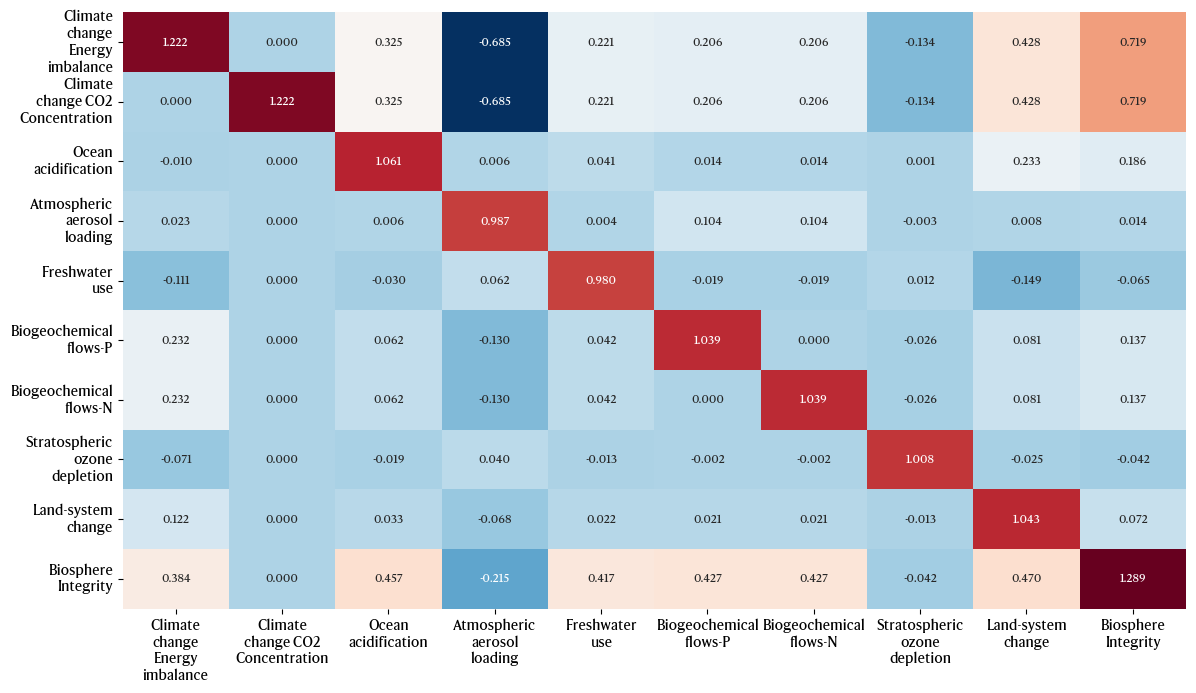

In [28]:
fig, ax = plt.subplots(figsize=(12,7))
kw_ag_font=Dict("fontproperties"=>font_prop, "fontsize"=> 8)
cbar_kw=Dict("label"=> "%")
Seaborn.heatmap(𝛐,ax=ax,cbar=false,annot=true,annot_kws=kw_ag_font, fmt=".03f",cbar_kws=cbar_kw,cmap="RdBu_r")
ax.set_xticklabels(catnames,rotation=0, ha="center",fontproperties=font_prop_labels,fontsize=10)
ax.set_yticklabels(catnames,rotation=0,fontproperties=font_prop,fontsize=10)
fig.tight_layout()
plt.savefig(respath*"interactions_bio.svg",bbox_inches="tight",transparent=true)
display(plt.gcf())
plt.close("all")


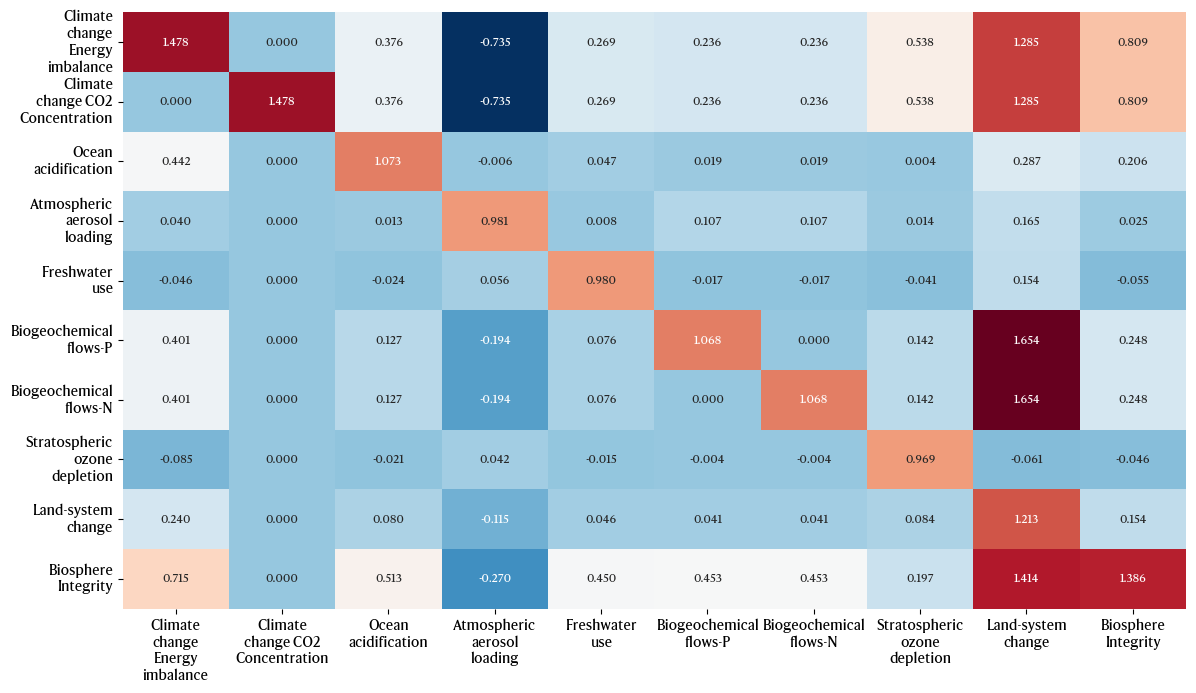

In [29]:
fig, ax = plt.subplots(figsize=(12,7))
kw_ag_font=Dict("fontproperties"=>font_prop, "fontsize"=> 8)
cbar_kw=Dict("label"=> "%")
Seaborn.heatmap(𝛄,ax=ax,cbar=false,annot=true,annot_kws=kw_ag_font, fmt=".03f",cbar_kws=cbar_kw,cmap="RdBu_r")
ax.set_xticklabels(catnames,rotation=0, ha="center",fontproperties=font_prop,fontsize=10)
ax.set_yticklabels(catnames,rotation=0,fontproperties=font_prop,fontsize=10)
fig.tight_layout()
plt.savefig(respath*"interactions_full.svg",bbox_inches="tight",transparent=true)
display(plt.gcf())
plt.close("all")


In [ ]:
𝚪ᵦ
𝚪ₕ
